In [88]:
import glob
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

In [89]:
paths = glob.glob('../results_hyper/*.txt')

In [90]:
path = paths[0]

In [91]:
def extract_row(path):
    with open(path) as fp:
        lines = fp.readlines()

        sel = list(filter(lambda line: line.startswith('{"startupTime":'), lines))
        row = json.loads(sel[0])

        _, mode, _, run = os.path.basename(path).split('-')
        run = int(run.replace('.txt', ''))
        row['mode'] = mode
        row['run'] = run
        row['path'] = path

        sel = list(filter(lambda line: 'LAMBDA compute took' in line, lines))[0]
        cost = float(sel[sel.find('cost $')+6:].strip())

        row['cost'] = cost

        return row

In [92]:
rows = []
for path in paths:
    rows.append(extract_row(path))
    
df = pd.DataFrame(rows)

In [93]:
df.groupby('mode').agg(['mean', 'std']).reset_index()

mode startupTime              jobTime            run            cost  \
                  mean       std       mean       std mean      std   mean   
0    hyper    0.208996  0.018164  47.310272  1.614773  5.5  3.02765  0.592   
1  nohyper    0.233714  0.019562  63.819428  0.873001  5.5  3.02765  0.932   

             
        std  
0  0.004216  
1  0.004216

In [94]:
#speedup
63.819428 / 47.310272

1.348955000723733

In [95]:
1.0 - 0.592 / 0.932 

0.36480686695278974

In [96]:
# maybe use different sampling modes?

In [97]:
# generate the table from path info

In [98]:
def extract_path_stats_row(path):
    with open(path) as fp:
        lines = fp.readlines()
        needle = 'LAMBDA paths rows took:'
        sel = list(filter(lambda line: needle in line, lines))[0]

        sel = sel[sel.find('normal:'):]

        _, normal, _, general, _, interpreter, _, unresolved = sel.strip().split(' ')


        row = {'normal' : int(normal),
               'general': int(general),
               'interpreter' : int(interpreter),
               'unresolved' : int(unresolved)}

        _, mode, _, run = os.path.basename(path).split('-')
        row['mode'] = mode
    return row

In [99]:
df_rows = pd.DataFrame([extract_path_stats_row('../results_hyper/flights-hyper-run-1.txt'),
                       extract_path_stats_row('../results_hyper/flights-nohyper-run-1.txt')])

In [100]:
df_rows.style.format(thousands=",")
print(df_rows[['mode', 'normal', 'general', 'interpreter', 'unresolved']].to_latex(index=None))

\begin{tabular}{lrrrr}
\toprule
    mode &     normal &    general &  interpreter &  unresolved \\
\midrule
   hyper &  149930703 &   44830574 &      7687788 &      238590 \\
 nohyper &     448620 &  179364496 &     22635949 &      238590 \\
\bottomrule
\end{tabular}



In [101]:
!cat ../results_hyper/flights-hyper-run-1.txt

[2022-06-14 08:47:14.544] [memory] [info] allocated bitmap managed memory region (2.00 GB, 32.00 MB block size)
[2022-06-14 08:47:14.544] [aws-lambda] [info] Execution over lambda with 10000MB
[2022-06-14 08:47:14.544] [aws-lambda] [info] Adjusted lambda size to 10000MB
[2022-06-14 08:47:14.686] [aws-lambda] [info] Found AWS Lambda function tuplex-lambda-runner (10000MB)
[2022-06-14 08:47:14.686] [aws-lambda] [info] Using Lambda running on x86_64
[2022-06-14 08:47:14.686] [aws-lambda] [info] Lambda client uses JSON AST serialization format.
[2022-06-14 08:47:14.963] [fileinputoperator] [info] found 410 files (83.51 GB) to process.
[2022-06-14 08:47:15.035] [global] [info] sampled s3://tuplex-public/data/flights_all/flights_on_time_performance_1987_10.csv on 256.00 KB
[2022-06-14 08:47:15.035] [fileinputoperator] [info] Parallel sample fetch done.
[2022-06-14 08:47:15.035] [fileinputoperator] [info] Filling sample cache for csv operator took 0.071980s (1 entries, 0 rows)
[2022-06-14 08:

## paper figure

In [102]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import seaborn as sns

from matplotlib.patches import Patch
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from matplotlib.path import *

In [103]:
# adjust settings for final paper (colors & Co)
def adjust_settings():
    # make nice looking plot

    sns.set_style('whitegrid')
    sns.set_context('poster')  # Everything is larger

    # matplotlib.rcParams['font.family'] = "serif"

    # red 900c3f

    # 48A70B
    sns.set_palette(
        [[.22, .52, .71], [.53, .80, .81], [144 / 255., 12 / 255, 63 / 255.], [67 / 255., 135 / 255., 107 / 255.],
         [248 / 255., 194 / 255., 145 / 255.]])

    matplotlib.rc('font', family='serif', size=9)
    matplotlib.rc('text.latex', preamble=['\\usepackage{times,mathptmx}'])
    matplotlib.rc('text', usetex=True)
    matplotlib.rc('legend', fontsize=8)
    matplotlib.rc('figure', figsize=(2.5, 1.4))
    matplotlib.rc('axes', linewidth=0.5)
    matplotlib.rc('lines', linewidth=0.5)

In [104]:
total = df_rows[['normal', 'general', 'interpreter', 'unresolved']].iloc[0].sum()

In [105]:
assert total == df_rows[['normal', 'general', 'interpreter', 'unresolved']].iloc[1].sum()

In [106]:
total

202687655

In [113]:
df_rows = df_rows.sort_values(by='normal', ascending=True).reset_index(drop=True)

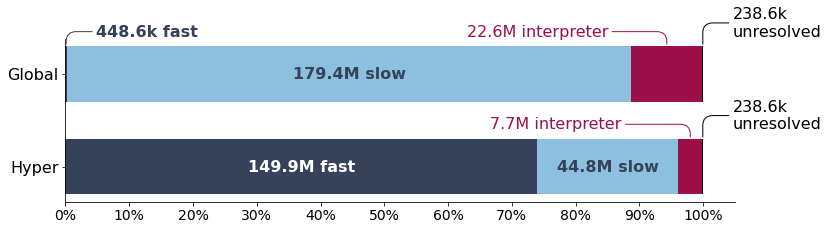

In [195]:
rel = 0
h = 0.6
plt.figure(figsize=(12, 3))
ax = plt.gca()
# https://matplotlib.org/stable/tutorials/text/annotations.html#sphx-glr-tutorials-text-annotations-py
# https://matplotlib.org/stable/gallery/text_labels_and_annotations/annotation_demo.html
n_col = np.array([53, 66, 89]) / 255.0#sns.color_palette()[0]
g_col = np.array([140, 192, 222]) / 255.0 #sns.color_palette()[1]
i_col = np.array([156, 15, 72]) / 255.0 #sns.color_palette()[2]

tg_col = n_col
yq = np.arange(len(df_rows))[::-1]
plt.barh(yq, df_rows['normal'] / total, h, left=rel, color=n_col)

m = rel + df_rows['normal'] / total * .5
ax.text(m[1], 0, '{:.1f}M fast'.format(df_rows['normal'].iloc[1] / 10**6),
        va='center', ha='center', fontsize=16, color='w', fontweight='bold',)

rel += df_rows['normal'] / total
plt.barh(yq, df_rows['general'] / total, h, left=rel, color=g_col)

m = rel + df_rows['general'] / total * .5
ax.text(m[0], 1, '{:.1f}M slow'.format(df_rows['general'].iloc[0] / 10**6),
        va='center', ha='center', fontsize=16, color=tg_col, fontweight='bold',)
ax.text(m[1], 0, '{:.1f}M slow'.format(df_rows['general'].iloc[1] / 10**6),
        va='center', ha='center', fontsize=16, color=tg_col, fontweight='bold',)


rel += df_rows['general'] / total
plt.barh(yq, df_rows['interpreter'] / total, h, left=rel, color=i_col)
rel += df_rows['interpreter'] / total
plt.barh(yq, df_rows['unresolved'] / total, h, left=rel, color='k')
xq = np.arange(0, 1.1, 0.1)


ax.annotate(
    '{:.1f}k fast'.format(df_rows['normal'].iloc[0] / 1000.0),
    xy=(df_rows['normal'].iloc[0] / total * 0.5, 1 + h/2), xycoords='data',
    xytext=(30, 10), fontsize=16, textcoords='offset points', color=n_col, fontweight='bold',
    arrowprops=dict(arrowstyle="-", color=n_col,
                    connectionstyle="angle,angleA=0,angleB=90,rad=10"))

ax.annotate(
    '{:.1f}k\nunresolved'.format(df_rows['unresolved'].iloc[0] / 1000.0),
    xy=(1.0 - df_rows['unresolved'].iloc[0] / total * 0.5, 1 + h/2), xycoords='data',
    xytext=(30, 10), fontsize=16, textcoords='offset points',
    arrowprops=dict(arrowstyle="-",
                    connectionstyle="angle,angleA=0,angleB=90,rad=10"))
ax.annotate(
    '{:.1f}k\nunresolved'.format(df_rows['unresolved'].iloc[0] / 1000.0),
    xy=(1.0 - df_rows['unresolved'].iloc[0] / total * 0.5, h/2), xycoords='data',
    xytext=(30, 10), fontsize=16, textcoords='offset points',
    arrowprops=dict(arrowstyle="-",
                    connectionstyle="angle,angleA=0,angleB=90,rad=10"))

ax.annotate(
    '{:.1f}M interpreter'.format(df_rows['interpreter'].iloc[0] / 10**6),
    xy=(1.0 - df_rows['unresolved'].iloc[0] / total - df_rows['interpreter'].iloc[0] / total * 0.5, 1 + h/2),
    xycoords='data', color=i_col,
    xytext=(-200, 10), fontsize=16, textcoords='offset points',
    arrowprops=dict(arrowstyle="-", color=i_col, 
                    connectionstyle="angle,angleA=0,angleB=90,rad=10"))

ax.annotate(
    '{:.1f}M interpreter'.format(df_rows['interpreter'].iloc[1] / 10**6),
    xy=(1.0 - df_rows['unresolved'].iloc[0] / total - df_rows['interpreter'].iloc[1] / total * 0.5, h/2),
    xycoords='data', color=i_col,
    xytext=(-200, 10), fontsize=16, textcoords='offset points',
    arrowprops=dict(arrowstyle="-", color=i_col,
                    connectionstyle="angle,angleA=0,angleB=90,rad=10"))

plt.xticks(xq, ['{}%'.format(int(x * 100)) for x in xq], fontsize=14)
plt.yticks([0, 1], ['Hyper', 'Global'], fontsize=16)
sns.despine()

plt.savefig('workshop_path_breakdown.pdf', transparent=True, dpi=120, bbox_inches = 'tight', pad_inches = 0)

In [140]:
print(m)

0    0.444679
1    0.850303
dtype: float64


In [37]:
help(plt.barh)

Help on function barh in module matplotlib.pyplot:

barh(y, width, height=0.8, left=None, *, align='center', **kwargs)
    Make a horizontal bar plot.
    
    The bars are positioned at *y* with the given *align*\ment. Their
    dimensions are given by *width* and *height*. The horizontal baseline
    is *left* (default 0).
    
    Many parameters can take either a single value applying to all bars
    or a sequence of values, one for each bar.
    
    Parameters
    ----------
    y : float or array-like
        The y coordinates of the bars. See also *align* for the
        alignment of the bars to the coordinates.
    
    width : float or array-like
        The width(s) of the bars.
    
    height : float or array-like, default: 0.8
        The heights of the bars.
    
    left : float or array-like, default: 0
        The x coordinates of the left sides of the bars.
    
    align : {'center', 'edge'}, default: 'center'
        Alignment of the base to the *y* coordinates*:
 